# Preparing Data

In [1]:
import torch
import numpy as np
import time
from pyDOE import lhs

# Domain Bounds
lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1.0])

# Grid Parameters
Nx = 256
Ny = 256
x = np.linspace(lb[0], ub[0], Nx)
y = np.linspace(lb[1], ub[1], Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# True Solution Parameters
a_1 = 1.0
a_2 = 1.0
k = 1.0

# Exact Solution (same as in the notebook)
def exact_solution(x, y):
    return np.sin(a_1 * np.pi * x) * np.sin(a_2 * np.pi * y)

usol = exact_solution(X, Y)

# Generate Training and Collocation Points
def get_training_data(N_u, N_f):
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Latin Hypercube Sampling for collocation points

    # Boundary Points
    edge_indices = np.array([0, Nx-1])
    left_right_x = X[:, edge_indices].flatten(order='F')[:, None] # Nx x 2 -> 2Nx x 1
    left_right_y = Y[:, edge_indices].flatten(order='F')[:, None] # Ny x 2 -> 2Ny x 1
    top_bottom_x = X[edge_indices, :].T.flatten(order='F')[:, None] # 2 x Nx ->Nx x 2 -> 2Nx x 1
    top_bottom_y = Y[edge_indices, :].T.flatten(order='F')[:, None] # 2 x Ny ->Ny x 2 -> 2Ny x 1

    x_u_train = np.hstack([
        np.vstack([left_right_x, top_bottom_x]), # x coord of edge, 4Nx x 1
        np.vstack([left_right_y, top_bottom_y])  # y coord of edge, 4Ny x 1
    ])
    # Random sampling of training points
    idx = np.random.choice(x_u_train.shape[0], N_u, replace=False) # N_u x 1
    x_u_train = x_u_train[idx, :]
    u_train = exact_solution(x_u_train[:, 0], x_u_train[:, 1])[:, None]

    return torch.tensor(X_f, dtype=torch.float32), torch.tensor(x_u_train, dtype=torch.float32), torch.tensor(u_train, dtype=torch.float32)

# Number of Data Points and Collocation Points
N_u = 400
N_f = 10000

# Get the training data
X_f_train, X_u_train, u_train = get_training_data(N_u, N_f)


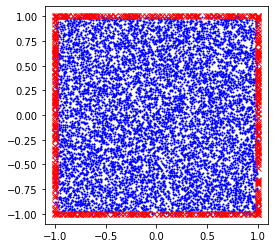

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.plot(X_f_train[:, 0], X_f_train[:, 1], 'bo', markersize=1)
plt.plot(X_u_train[:, 0], X_u_train[:, 1], 'rx')

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

class PINN(nn.Module):
    def __init__(self, layers, a_1, a_2, k):
        super(PINN, self).__init__()
        self.layers = layers
        self.loss_function = nn.MSELoss() # "mean" squared error

        # Parameters
        self.a_1 = nn.Parameter(torch.tensor(0.0), requires_grad=True) # a_1
        self.a_2 = nn.Parameter(torch.tensor(0.0), requires_grad=True) # a_2
        self.k = k

        # Neural Network
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.activation = nn.Tanh()

        # Xavier Initialization
        for i in range(len(self.linears)):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) # set range to [-gain * sqrt(2/(in+out)), gain * sqrt(2/(in+out))]
            if self.linears[i].bias is not None:
                nn.init.zeros_(self.linears[i].bias.data)
    
    def forward(self, x):
        u_b = torch.from_numpy(ub).float()
        l_b = torch.from_numpy(lb).float()
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        for linear in self.linears[:-1]:
            x = self.activation(linear(x))
        x = self.linears[-1](x)  # No activation on the last layer (u)
        return x
    
    def compute_loss(self, x_u, u_true, x_f, k):
        x_f.requires_grad = True
        # Calculate u from the network at boundary points and collocation points
        u_f_pred = self.forward(x_f)
        
        # Compute f (similar to TensorFlow implementation)
        u_f_pred_grads = torch.autograd.grad(u_f_pred, x_f, grad_outputs=torch.ones_like(u_f_pred), retain_graph=True, create_graph=True)[0]
        # to calculate u_x1x1 and u_x2x2, we need u_x1, u_x2 with autograd on x_f = [x1, x2]
        u_f_pred_xx1 = torch.autograd.grad(u_f_pred_grads[:,[0]], x_f, grad_outputs=torch.ones_like(u_f_pred_grads[:,[0]]), create_graph=True)[0][:, [0]]
        u_f_pred_xx2 = torch.autograd.grad(u_f_pred_grads[:,[1]], x_f, grad_outputs=torch.ones_like(u_f_pred_grads[:,[1]]), create_graph=True)[0][:, [1]]

        rhs = -( (self.a_1*torch.pi)**2 + (self.a_2*torch.pi)**2 - self.k**2 ) * torch.sin(self.a_1*torch.pi*x_f[:,[0]]) * torch.sin(self.a_2*torch.pi*x_f[:,[1]]) # Forcing term

        f_pred = u_f_pred_xx1 + u_f_pred_xx2 + k**2 * u_f_pred - rhs
        
        # Calculate the loss
        loss_f = self.loss_function(f_pred, torch.zeros_like(f_pred)) # residual loss
        u_pred = self.forward(x_u)
        loss_u = self.loss_function(u_pred, u_true) # boundary loss
        loss = loss_f + loss_u

        return loss, loss_u, loss_f

    def train(self, x_u, u_true, x_f, k, epochs, lr):
        # adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr,betas=(0.9, 0.999), eps=1e-07)
        for epoch in range(epochs): # loop over the dataset multiple times
            optimizer.zero_grad()
            loss, loss_u, loss_f = self.compute_loss(x_u, u_true, x_f, k)
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0: # Print the loss every 100 epochs
                print(f"Epoch {epoch}, loss_BC: {loss_u.item():.5f}, loss_f: {loss_f.item():.5f}, loss: {loss.item():.5f}")

# PINN Setup and Training
layers = [2, 50, 50, 50, 1]
model = PINN(layers, a_1, a_2, k)
epochs = 1000
learning_rate = 1e-3
start_time = time.time()

model.train(X_u_train, u_train, X_f_train, k, epochs, learning_rate)
print(f"Training time: {time.time() - start_time:.2f} seconds")

Epoch 0, loss_BC: 0.21909, loss_f: 87.63074, loss: 87.84984
Epoch 100, loss_BC: 1.05880, loss_f: 31.97902, loss: 33.03782
Epoch 200, loss_BC: 1.38270, loss_f: 2.94840, loss: 4.33110
Epoch 300, loss_BC: 0.36349, loss_f: 0.55222, loss: 0.91571
Epoch 400, loss_BC: 0.03530, loss_f: 0.08852, loss: 0.12382
Epoch 500, loss_BC: 0.02346, loss_f: 0.03983, loss: 0.06330
Epoch 600, loss_BC: 0.02260, loss_f: 0.02857, loss: 0.05117
Epoch 700, loss_BC: 0.02164, loss_f: 0.02293, loss: 0.04457
Epoch 800, loss_BC: 0.02049, loss_f: 0.04214, loss: 0.06264
Epoch 900, loss_BC: 0.01989, loss_f: 0.01628, loss: 0.03617


TypeError: 'float' object is not callable

In [11]:
x_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))
x_test_tensor = torch.from_numpy(x_test).float()

u = model.forward(x_test_tensor)
u_pred = np.reshape(u.detach().numpy(), (Nx,Nx), order='F')

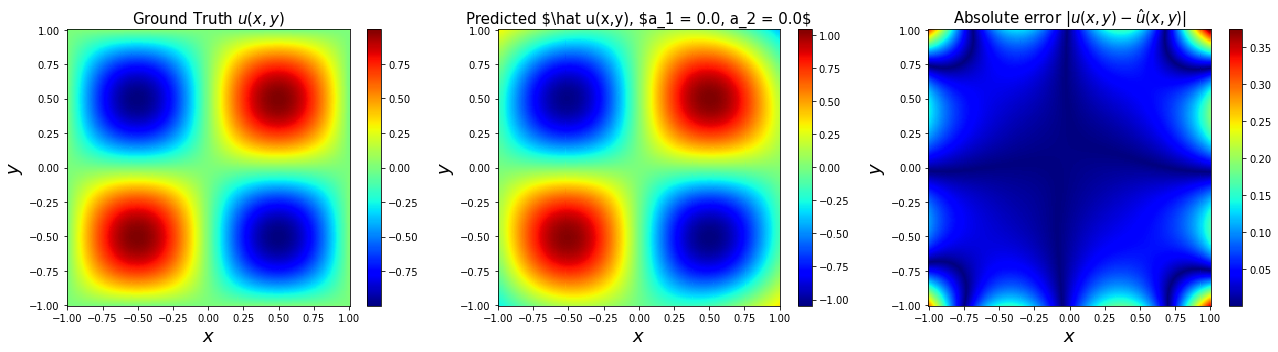

In [20]:
fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(X, Y, usol, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)
plt.title('Ground Truth $u(x,y)$', fontsize=15)

# Prediction
plt.subplot(1, 3, 2)
plt.pcolor(X, Y, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)
plt.title(r'Predicted $\hat u(x,y),'+fr' $a_1 = {model.a_1.item()}, a_2 = {model.a_2.item()}$', fontsize=15)

# Error
plt.subplot(1, 3, 3)
plt.pcolor(X, Y, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)
plt.title(r'Absolute error $|u(x,y)- \hat u(x,y)|$', fontsize=15)
plt.tight_layout()
# plt.savefig('Helm.png', dpi=300)
plt.show()